# Load Data amd Preprocess

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report
from lightgbm import LGBMClassifier
import warnings

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Train shape: (101658, 47)
Test shape: (25889, 46)


,id,player_id,play_frequency,avg_session_duration,total_playtime_hours,login_streak,days_since_last_login,total_spending_thb,avg_monthly_spending,spending_frequency,...,platform,device_type,payment_method,language,account_status,player_type_tag,engagement_level,loyalty_tier,skill_tier,segment
0,PLY00001,P050236,5.495437,24.837349,2740.945124,60.0,56.034052,58219.915660,434.038311,17.790970,...,PC,Phone,Wallet,DE,Active,Social,Low,Silver,NaN,0
1,PLY00002,P108696,9.991089,88.376322,NaN,22.0,75.036888,28966.163953,4233.532935,28.862134,...,Console,Desktop,Card,ES,Dormant,Collector,Low,Platinum,Gold,2
2,PLY00003,P113532,14.234225,101.712292,2828.479467,66.0,NaN,44478.823835,4849.491895,22.536406,...,PC,Laptop,NaN,EN,Dormant,Casual,High,Diamond,Gold,3
3,PLY00004,P123930,3.373683,191.975841,1915.082950,80.0,0.127910,57074.116993,6863.516123,10.565666,...,Console,Tablet,NaN,ES,Dormant,Competitive,Veteran,Silver,Gold,3
4,PLY00005,P068623,22.469353,28.042509,517.921948,NaN,45.078460,NaN,4408.101247,11.226504,...,PC,Tablet,Gift,EN,Active,Casual,Mid,Silver,NaN,1


In [ ]:
print("\nMissing values per column:")
print(train.isnull().sum())

print("\nData types:")
print(train.dtypes)


Missing values per column:
id                                      0
player_id                               0
play_frequency                       7873
avg_session_duration                 7887
total_playtime_hours                 7771
login_streak                         7720
days_since_last_login                7780
total_spending_thb                   7756
avg_monthly_spending                 7735
spending_frequency                   7760
friend_count                         7938
team_play_percentage                 7695
chat_activity_score                  7765
friend_invites_sent                  7835
gifts_sent_received                  7720
ranked_participation_rate            7825
tournament_entries                   7854
competitive_rank                     7795
win_rate_ranked                      7828
watches_esports                      7882
achievement_completion_rate          7894
collection_progress                  7914
rare_items_count                     7694
speed_

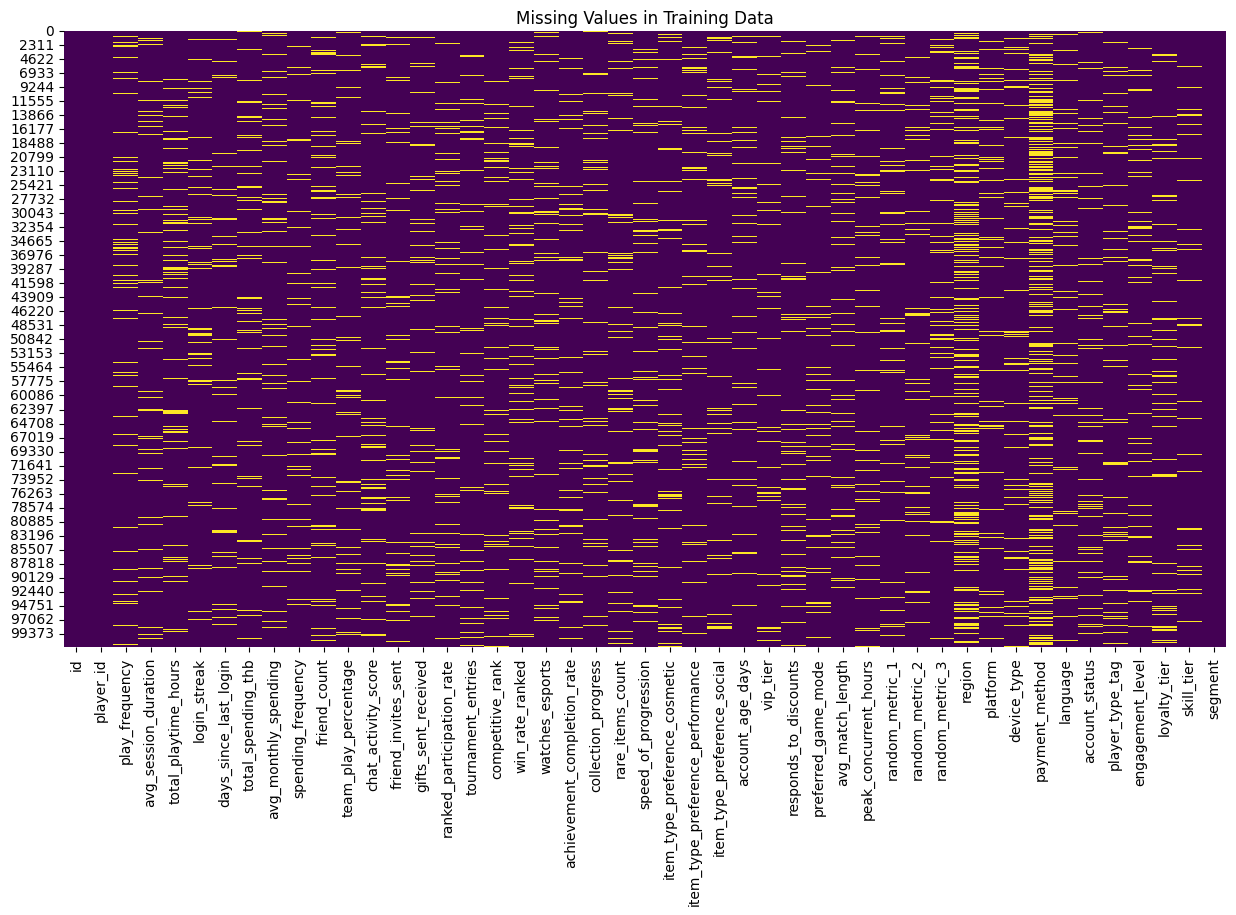

In [ ]:
plt.figure(figsize=(15, 8))
sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Training Data')
plt.show()

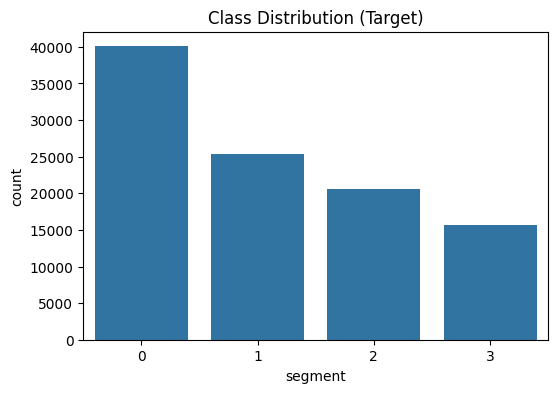

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x=train['segment'])
plt.title("Class Distribution (Target)")
plt.show()

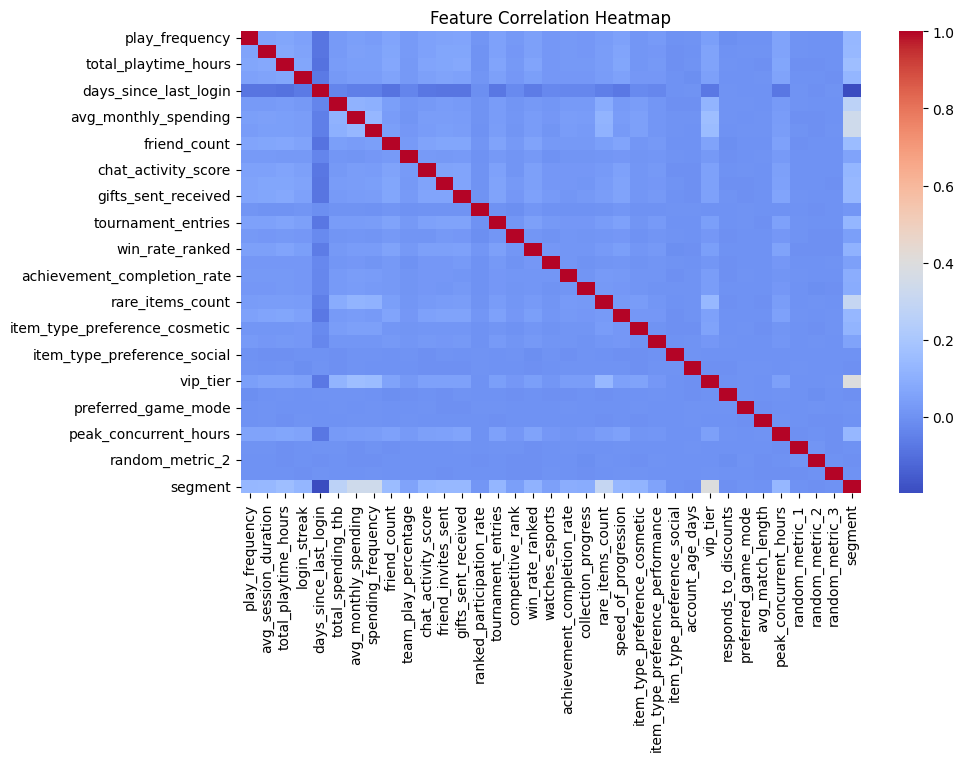

In [ ]:
num_cols = train.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10,6))
sns.heatmap(train[num_cols].corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

## Visualize Distributions Before Preprocessing



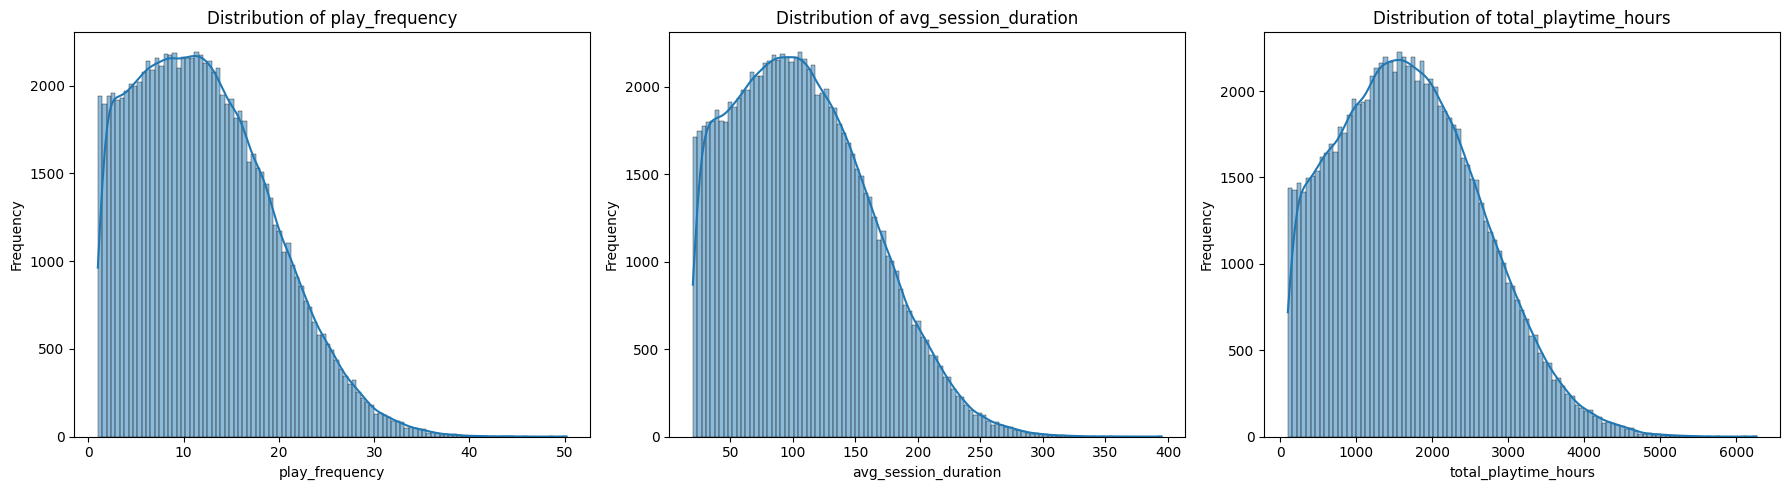

In [ ]:
numerical_features = ['play_frequency', 'avg_session_duration', 'total_playtime_hours']
plt.figure(figsize=(18, 5))

for i, feature in enumerate(numerical_features):
    plt.subplot(1, 3, i + 1)
    sns.histplot(train[feature].dropna(), kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

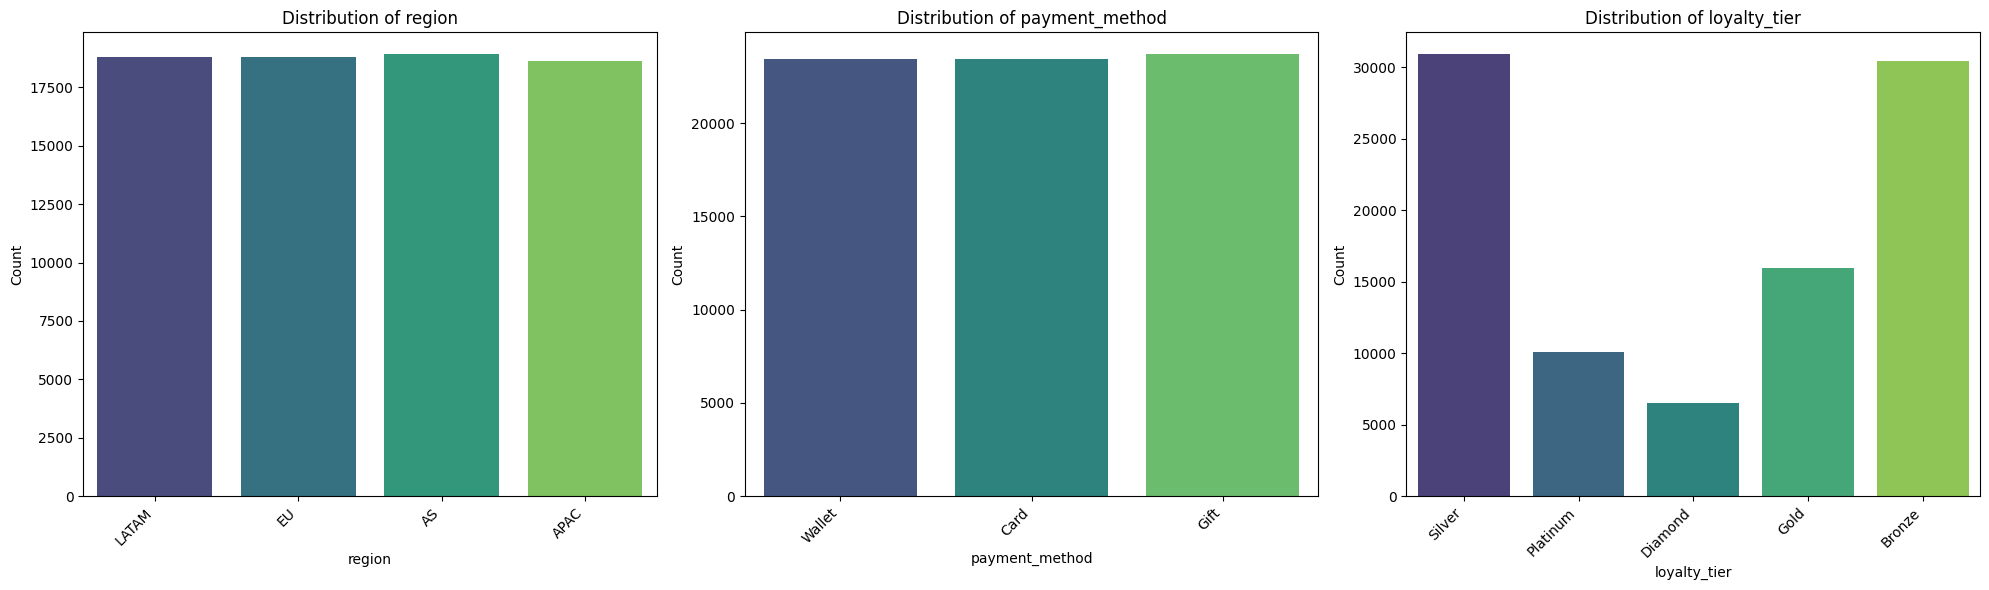

In [ ]:
categorical_features = ['region', 'payment_method', 'loyalty_tier']
plt.figure(figsize=(20, 6))

for i, feature in enumerate(categorical_features):
    plt.subplot(1, 3, i + 1)
    sns.countplot(data=train, x=feature, hue=feature, palette='viridis', legend=False)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right') # Rotate labels for better readability

plt.tight_layout()
plt.show()

In [ ]:
# Separate features and target
target = 'segment'
X = train.drop(columns=[target])
y = train[target]

# Combine train & test for consistent preprocessing
all_data = pd.concat([X, test], axis=0)

# Encode categorical features
cat_cols = all_data.select_dtypes(include=['object']).columns
for c in cat_cols:
    le = LabelEncoder()
    all_data[c] = le.fit_transform(all_data[c].astype(str))

# Fill missing values
all_data = all_data.fillna(all_data.median())

# Scale numeric features
scaler = StandardScaler()
num_cols = all_data.select_dtypes(include=[np.number]).columns
all_data[num_cols] = scaler.fit_transform(all_data[num_cols])

# Split back into train/test
X = all_data.iloc[:len(train), :]
X_test = all_data.iloc[len(train):, :]

## Visualize Distributions After Preprocessing


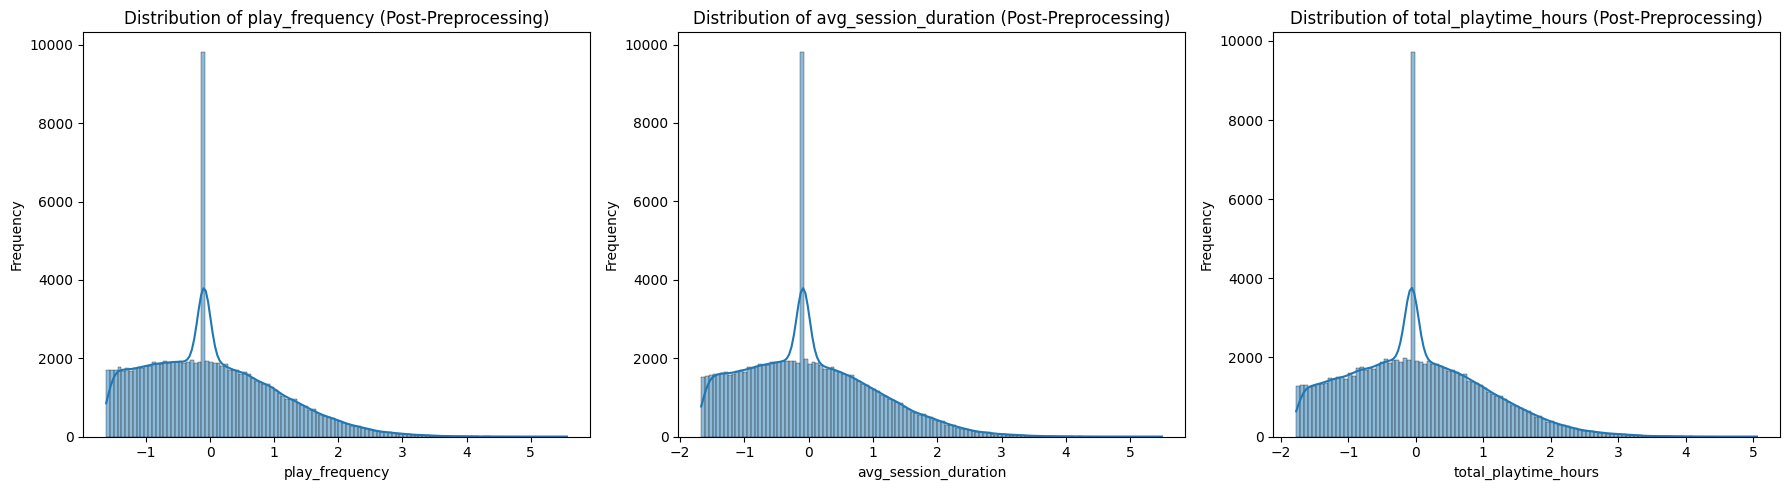

In [ ]:
numerical_features = ['play_frequency', 'avg_session_duration', 'total_playtime_hours']
plt.figure(figsize=(18, 5))

for i, feature in enumerate(numerical_features):
    plt.subplot(1, 3, i + 1)
    sns.histplot(X[feature], kde=True)
    plt.title(f'Distribution of {feature} (Post-Preprocessing)')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

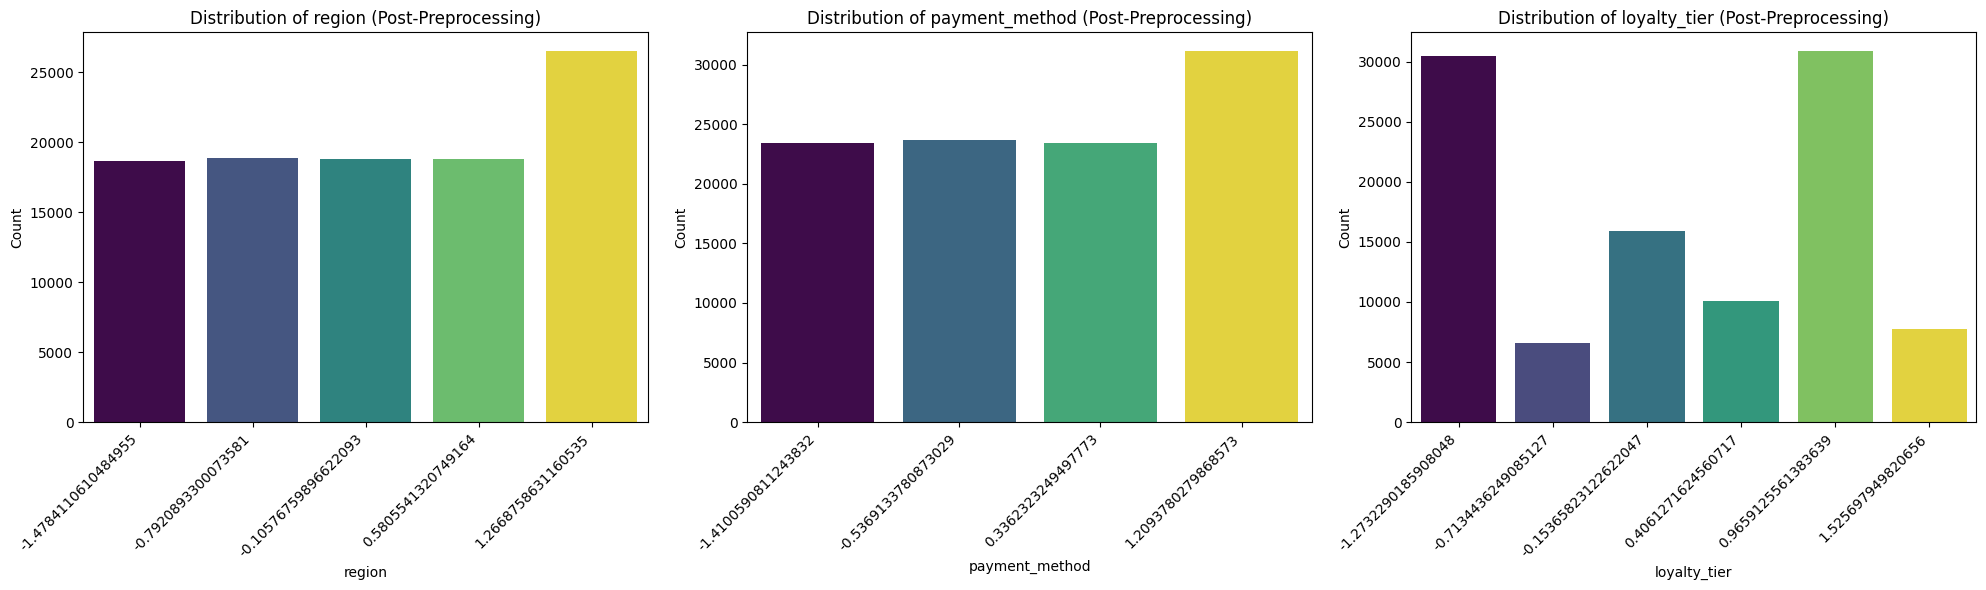

In [ ]:
categorical_features_post_prep = ['region', 'payment_method', 'loyalty_tier']
plt.figure(figsize=(20, 6))

for i, feature in enumerate(categorical_features_post_prep):
    plt.subplot(1, 3, i + 1)
    sns.countplot(data=X, x=feature, hue=feature, palette='viridis', legend=False)
    plt.title(f'Distribution of {feature} (Post-Preprocessing)')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

#Train Model LIghtGBM with k-Fold stratified

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(train))
test_preds = np.zeros((len(test), 4))

import lightgbm as lgb

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\n===== Fold {fold+1} =====")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.03,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='multi_logloss', # Use multi_logloss for multi-class classification
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)]

    )

    val_pred = model.predict(X_val)
    oof_preds[val_idx] = val_pred
    test_preds += model.predict_proba(X_test)


===== Fold 1 =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7682
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 46
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.386959
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871298
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[162]	valid_0's multi_logloss: 0.169381

===== Fold 2 =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7684
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 46
[LightGBM] [Info] Start traini

In [ ]:
# Evaluate the model on the OOF predictions
oof_f1 = f1_score(y, oof_preds, average='weighted')
print(f"\nOOF Weighted F1 Score: {oof_f1:.4f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y, oof_preds))

# Finalize test predictions
final_test_preds = np.argmax(test_preds, axis=1)


OOF Weighted F1 Score: 0.9685

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     40064
           1       0.97      0.97      0.97     25397
           2       0.97      0.96      0.96     20549
           3       0.97      0.94      0.95     15648

    accuracy                           0.97    101658
   macro avg       0.97      0.96      0.97    101658
weighted avg       0.97      0.97      0.97    101658



In [ ]:
# Create submission file
submission = pd.DataFrame({'id': test['id'], 'segment': final_test_preds})
submission.to_csv('submission.csv', index=False)

print("\nSubmission file created successfully!")


Submission file created successfully!
